Lasso Regression

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE

Implementation

In [25]:
def add_b0_coef(X: np.ndarray) -> np.ndarray:
  '''
  Adds a column for intercept calculation.
  '''
  ones = np.ones((X.shape[0], 1))
  return np.hstack((ones, X))

def lasso_regression(X: np.ndarray, Y: np.ndarray, B: np.array, alpha: float, lr: float, iters: int) -> np.array:
  '''
  Calculates regression coeeficients of the Lasso Regression using gradient descent.
  '''
  for _ in range(iters):
    # get predictions
    Y_pred = predict(X, B)
    Y_pred = np.reshape(Y_pred, (Y_pred.shape[0], 1))

    # calculate gradients in respect to beta
    coeff_grad = -2 * (X.T @ (Y - Y_pred))/(X.shape[0])
    l1_grad = alpha * np.sign(B)
    total_grad = coeff_grad + l1_grad

    # new beta
    B =  B - lr * total_grad

  return B

def predict(X: np.ndarray, B: np.ndarray) -> np.ndarray:
  '''
  Predicts target values.
  '''
  return X @ B

def mean_squared_error(Y_pred: np.ndarray, Y: np.ndarray) -> np.ndarray:
  '''
  Calculates the Mean Squared Error.
  '''
  return sum((Y - Y_pred)**2)/len(Y)

def lasso_cost(Y_pred: np.ndarray, Y: np.ndarray, alpha: float, beta: np.ndarray) -> float:
  '''
  Calculate cost function for Lasso Regression.
  '''
  mse = mean_squared_error(Y_pred, Y)

  return mse +  alpha * sum(np.abs(beta))

def R_squared(Y: np.ndarray, Y_pred: np.ndarray) -> np.ndarray:
  '''
  Calculate the coefficent of determination.
  '''
  nominator = sum(Y - Y_pred)**2
  denominator = sum(Y - np.mean(Y, axis=0))

  return 1 - nominator/denominator


Testing implementation on the sklearn diabetes dataset.


In [26]:
data = load_diabetes()

In [27]:
# add a column of ones
X = add_b0_coef(data.data)

# initilize beta randomly
B = np.random.rand(X.shape[1], 1)

# target value
Y = data.target.reshape(442,1)

# lasso regression with gradient descent
B = lasso_regression(X, Y, B, alpha=0.1, lr=0.1, iters=10000)

# get predictions
Y_pred = predict(X, B)
Y_pred = np.reshape(Y_pred, (Y_pred.shape[0], 1))

# get metrics
my_cost = lasso_cost(Y_pred, data.target, 0.1, B)
my_mse = mean_squared_error(Y_pred, data.target.reshape(442,1))
my_r_squared = R_squared(data.target, Y_pred)

Now, running the regression with the default sklearn Lasso Regression, for comparison.

In [28]:
# instantiate model
model = Lasso(alpha=0.1)

# get solution
model.fit(X, data.target)

# get predictions
y_pred = model.predict(X)

# obtain metrics
mse = MSE(data.target, y_pred)
r_squared = R_squared(data.target, y_pred)

Finally, comparing results:

In [29]:
print(f'My MSE: {my_mse[0]:.2f}, sklearn MSE: {mse:.2f}')
print(f'My Intercept: {B[0, 0]:.2f}, sklearn Intercept: {model.intercept_:.2f}')
formatted= [f'{c:.2f}' for c in model.coef_[1:]]
my_formatted = [f'{c:.2f}' for c in B[1:, 0]]
print(f'My Coefficients: {my_formatted}, \nsklearn Coefficients: {formatted}')

My MSE: 2890.48, sklearn MSE: 2912.53
My Intercept: 152.08, sklearn Intercept: 152.13
My Coefficients: ['0.00', '-194.66', '518.64', '299.38', '-37.98', '-83.65', '-202.23', '79.36', '447.43', '68.43'], 
sklearn Coefficients: ['-0.00', '-155.36', '517.19', '275.08', '-52.54', '-0.00', '-210.16', '0.00', '483.91', '33.67']


Accurate implementation.

Now, executing a K-Fold train/test in search of the best possible value for the regularization factor $\alpha$.

In [30]:
# target values
Y = data.target.reshape(442,1)

# alphas to test
possible_alphas = np.arange(0.0000, 0.012, 0.0002)

# initilize beta randomly
B = np.random.rand(X.shape[1], 1)

# test
mean_mse_list = []
mean_cost_list = []
kf = KFold(n_splits=5, shuffle=True, random_state=26)

# iter throught alphas
for alpha in possible_alphas:
  mse_list = []
  cost_list = []
  for train_index, test_index in kf.split(X):
    # separate train/test split
    X_train = X[train_index]
    Y_train = Y[train_index]

    X_test = X[test_index]
    Y_test = Y[test_index]

    # calculate solution
    B = lasso_regression(X_train, Y_train, B, alpha, lr=0.1, iters=10000)

    # get predictions
    Y_pred = predict(X_test, B)

    # get metrics
    cost = lasso_cost(Y_pred, Y_test, alpha, B)
    mse = mean_squared_error(Y_pred, Y_test)

    mse_list.append(mse)
    cost_list.append(cost)

  # get mean of all folds
  mean_mse_list.append(np.mean(mse_list))
  mean_cost_list.append(np.mean(cost_list))

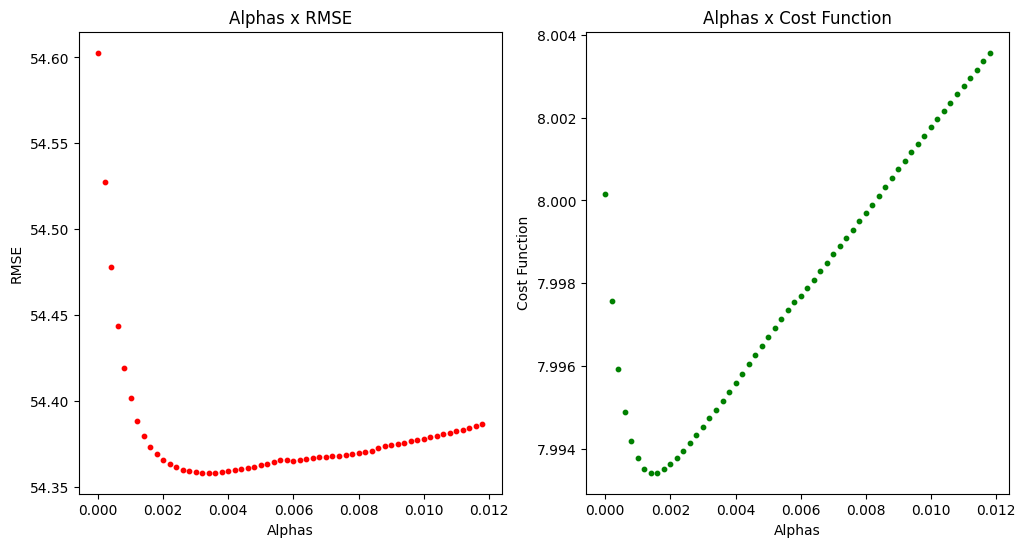

In [31]:
# plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(possible_alphas, np.sqrt(mean_mse_list), c='r', s=10)
axes[0].set_xlabel('Alphas')
axes[0].set_ylabel('RMSE')
axes[0].set_title('Alphas x RMSE')


axes[1].scatter(possible_alphas, np.log(mean_cost_list), c='g', s=10)
axes[1].set_xlabel('Alphas')
axes[1].set_ylabel('Cost Function')
axes[1].set_title('Alphas x Cost Function')

plt.show()

The best alpha is $0.0034$.